In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lightmooccubex/relations/course-teacher.txt
/kaggle/input/lightmooccubex/relations/concept-comment.txt
/kaggle/input/lightmooccubex/relations/user-video.json
/kaggle/input/lightmooccubex/relations/course-comment.txt
/kaggle/input/lightmooccubex/relations/concept-problem.txt
/kaggle/input/lightmooccubex/relations/user-reply.txt
/kaggle/input/lightmooccubex/relations/concept-video.txt
/kaggle/input/lightmooccubex/relations/course-school.txt
/kaggle/input/lightmooccubex/relations/user-comment.txt
/kaggle/input/lightmooccubex/relations/exercise-problem.txt
/kaggle/input/lightmooccubex/relations/concept-paper.txt
/kaggle/input/lightmooccubex/relations/reply-reply.txt
/kaggle/input/lightmooccubex/relations/course-field.json
/kaggle/input/lightmooccubex/relations/video_id-ccid.txt
/kaggle/input/lightmooccubex/relations/concept-reply.json
/kaggle/input/lightmooccubex/relations/comment-reply.txt
/kaggle/input/lightmooccubex/relations/concept-other.txt
/kaggle/input/lightmooccubex/

In [2]:
import polars as pl
from tqdm import tqdm
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

# Import data

In [3]:
reply_df = pl.read_ndjson('/kaggle/input/lightmooccubex/entities/reply.json')
reply_df = reply_df.rename({"id": "reply_id"})
reply_df.head()

reply_id,user_id,text,create_time
str,str,str,str
"""Rp_1""","""U_10030806""","""测试回复""","""2019-08-05 12:55:54"""
"""Rp_2""","""U_10031397""","""赞""","""2019-08-09 16:39:06"""
"""Rp_3""","""U_10031531""","""好喜欢""","""2019-08-10 22:39:35"""
"""Rp_4""","""U_10031508""","""你也好棒""","""2019-08-12 14:43:34"""
"""Rp_5""","""U_10031508""","""嗯对""","""2019-08-12 14:44:51"""


In [4]:
comment_df = pl.read_ndjson('/kaggle/input/lightmooccubex/entities/comment.json')
comment_df = comment_df.rename({"id": "comment_id"})
comment_df.head()

comment_id,user_id,text,resource_id,create_time
str,i64,str,str,str
"""Cm_1""",10030806,"""测试评论""",null,"""2019-08-05 12:55:27"""
"""Cm_4""",1705400,"""嗯嗯""",null,"""2019-08-05 16:56:43"""
"""Cm_5""",10031537,"""是的，我也看不到""",null,"""2019-08-07 21:05:38"""
"""Cm_7""",10031502,"""大师傅as""",null,"""2019-08-09 13:06:06"""
"""Cm_12""",10031397,"""点赞""",null,"""2019-08-09 16:38:56"""


In [5]:
user_df = pl.read_ndjson('/kaggle/input/lightmooccubex/entities/user.json')
user_df = user_df.rename({"id": "user_id"})
user_df.head()

user_id,name,gender,school,year_of_birth,course_order,enroll_time
str,str,i64,str,i64,list[i64],list[str]
"""U_22""","""我""",0,"""""",2015,"[682129, 2294668]","[""2019-10-12 10:28:02"", ""2020-11-21 14:03:28""]"
"""U_24""","""王帅国""",1,"""清华大学""",6558,"[597214, 605512, … 2229905]","[""2019-05-20 16:06:48"", ""2019-05-24 19:34:43"", … ""2020-11-21 11:38:57""]"
"""U_25""","""王帅国""",0,"""清华大学""",null,[1903985],"[""2020-08-07 18:59:13""]"
"""U_53""","""于歆杰""",1,"""清华大学""",1973,"[696679, 1704639, … 1794464]","[""2020-03-01 21:24:30"", ""2020-03-12 16:17:02"", … ""2020-06-18 18:47:15""]"
"""U_54""","""马昱春""",2,"""清华大学""",null,"[682442, 682164, … 1906706]","[""2019-10-09 02:17:49"", ""2019-11-08 00:49:03"", … ""2020-07-20 11:27:28""]"


In [6]:
course_comment = pd.read_csv('/kaggle/input/lightmooccubex/relations/course-comment.txt', 
                             sep="\t", header=None, names=["course_id", "comment_id"])
course_comment.head()

,course_id,comment_id
0,C_597284,Cm_4
1,C_597334,Cm_61
2,C_682246,Cm_74
3,C_697602,Cm_83
4,C_605983,Cm_88


In [7]:
comment_reply = pd.read_csv('/kaggle/input/lightmooccubex/relations/comment-reply.txt',
                             sep="\t", header=None, names=["comment_id", "reply_id"])

comment_reply.head()

,comment_id,reply_id
0,Cm_1,Rp_1
1,Cm_12,Rp_2
2,Cm_24,Rp_3
3,Cm_43,Rp_4
4,Cm_44,Rp_5


In [8]:
reply_reply = pd.read_csv('/kaggle/input/lightmooccubex/relations/reply-reply.txt',
                             sep="\t", header=None, names=["reply_of_rep_id", "reply_id"])

reply_reply.head()

,reply_of_rep_id,reply_id
0,Rp_19,Rp_18
1,Rp_25,Rp_24
2,Rp_46,Rp_40
3,Rp_55,Rp_28
4,Rp_62,Rp_61


# EDA cơ bản

In [9]:
reply_pd = reply_df.to_pandas()
reply_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331011 entries, 0 to 331010
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   reply_id     331011 non-null  object
 1   user_id      331011 non-null  object
 2   text         331011 non-null  object
 3   create_time  331011 non-null  object
dtypes: object(4)
memory usage: 10.1+ MB


In [10]:
comment_pd = comment_df.to_pandas()
comment_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8395141 entries, 0 to 8395140
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   comment_id   object
 1   user_id      int64 
 2   text         object
 3   resource_id  object
 4   create_time  object
dtypes: int64(1), object(4)
memory usage: 320.2+ MB


In [11]:
user_pd = user_df.to_pandas()
user_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330294 entries, 0 to 3330293
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   name           object 
 2   gender         float64
 3   school         object 
 4   year_of_birth  float64
 5   course_order   object 
 6   enroll_time    object 
dtypes: float64(2), object(5)
memory usage: 177.9+ MB


In [12]:
comments_per_reply_counts = comment_reply["reply_id"].value_counts() # Check số comments thuộc về 1 reply
multiple_replies = comments_per_reply_counts[comments_per_reply_counts > 1]

print(multiple_replies)

Series([], Name: count, dtype: int64)


# Gộp các file

In [13]:
reply_data = reply_pd.merge(comment_reply, on="reply_id", how="left")
reply_data.head(10)

,reply_id,user_id,text,create_time,comment_id
0,Rp_1,U_10030806,测试回复,2019-08-05 12:55:54,Cm_1
1,Rp_2,U_10031397,赞,2019-08-09 16:39:06,Cm_12
2,Rp_3,U_10031531,好喜欢,2019-08-10 22:39:35,Cm_24
3,Rp_4,U_10031508,你也好棒,2019-08-12 14:43:34,Cm_43
4,Rp_5,U_10031508,嗯对,2019-08-12 14:44:51,Cm_44
5,Rp_6,U_10031508,人工智能是,2019-08-12 14:47:58,Cm_45
6,Rp_7,U_10031536,我的观点就是，你说啥就时啥,2019-08-13 09:41:32,Cm_60
7,Rp_8,U_10031536,我的观点就是，你说啥就时啥,2019-08-13 09:41:42,Cm_60
8,Rp_9,U_10031536,我的观点就是，你说啥就时啥,2019-08-13 09:41:53,Cm_59
9,Rp_10,U_10031536,我的观点就是，你说啥就时啥,2019-08-13 09:41:59,Cm_59


In [14]:
reply_data.isnull().sum()

reply_id       0
user_id        0
text           0
create_time    0
comment_id     0
dtype: int64

In [15]:
reply_data = reply_data.merge(course_comment, on="comment_id", how="left")
reply_data.head(10)

,reply_id,user_id,text,create_time,comment_id,course_id
0,Rp_1,U_10030806,测试回复,2019-08-05 12:55:54,Cm_1,NaN
1,Rp_2,U_10031397,赞,2019-08-09 16:39:06,Cm_12,NaN
2,Rp_3,U_10031531,好喜欢,2019-08-10 22:39:35,Cm_24,NaN
3,Rp_4,U_10031508,你也好棒,2019-08-12 14:43:34,Cm_43,NaN
4,Rp_5,U_10031508,嗯对,2019-08-12 14:44:51,Cm_44,NaN
5,Rp_6,U_10031508,人工智能是,2019-08-12 14:47:58,Cm_45,NaN
6,Rp_7,U_10031536,我的观点就是，你说啥就时啥,2019-08-13 09:41:32,Cm_60,NaN
7,Rp_8,U_10031536,我的观点就是，你说啥就时啥,2019-08-13 09:41:42,Cm_60,NaN
8,Rp_9,U_10031536,我的观点就是，你说啥就时啥,2019-08-13 09:41:53,Cm_59,NaN
9,Rp_10,U_10031536,我的观点就是，你说啥就时啥,2019-08-13 09:41:59,Cm_59,NaN


In [16]:
reply_data['course_id'].isnull().sum()

184194

In [17]:
# Chuyển đổi thứ tự cột
reply_user = reply_data[['reply_id', 'user_id', 'course_id', 'comment_id', 'text', 'create_time']]
reply_user.head()

,reply_id,user_id,course_id,comment_id,text,create_time
0,Rp_1,U_10030806,NaN,Cm_1,测试回复,2019-08-05 12:55:54
1,Rp_2,U_10031397,NaN,Cm_12,赞,2019-08-09 16:39:06
2,Rp_3,U_10031531,NaN,Cm_24,好喜欢,2019-08-10 22:39:35
3,Rp_4,U_10031508,NaN,Cm_43,你也好棒,2019-08-12 14:43:34
4,Rp_5,U_10031508,NaN,Cm_44,嗯对,2019-08-12 14:44:51


In [18]:
reply_user["course_id_clean"] = reply_user["course_id"].str.replace("C_", "", regex=False)  

<ipython-input-18-24f16d31203f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_user["course_id_clean"] = reply_user["course_id"].str.replace("C_", "", regex=False)


In [19]:
reply_user.dropna(subset=['course_id', 'user_id'], inplace=True)
reply_user.head()

<ipython-input-19-4ca5bb4cfff5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reply_user.dropna(subset=['course_id', 'user_id'], inplace=True)


,reply_id,user_id,course_id,comment_id,text,create_time,course_id_clean
11,Rp_13,U_11731,C_696700,Cm_102,发达,2019-09-05 14:50:14,696700
12,Rp_14,U_11731,C_696700,Cm_102,打发,2019-09-05 14:50:18,696700
13,Rp_15,U_11731,C_696700,Cm_100,打发大水,2019-09-05 14:50:26,696700
14,Rp_16,U_6875014,C_734023,Cm_224,嗯,2019-09-06 18:40:35,734023
16,Rp_18,U_11031591,C_696814,Cm_320,我说的是如果,2019-09-09 19:00:15,696814


In [20]:
user = user_pd
user["course_enroll_map"] = user.apply(
    lambda row: dict(zip(row["course_order"], row["enroll_time"])), axis=1
)

In [21]:
reply_user = reply_user.merge(user[['user_id', 'course_enroll_map']], on='user_id', how='left')

In [22]:
reply_user.isnull().sum()

reply_id                 0
user_id                  0
course_id                0
comment_id               0
text                     0
create_time              0
course_id_clean          0
course_enroll_map    34052
dtype: int64

In [23]:
reply_user["course_id_clean"] = reply_user["course_id_clean"].astype(int)

In [24]:
reply_user.head()

,reply_id,user_id,course_id,comment_id,text,create_time,course_id_clean,course_enroll_map
0,Rp_13,U_11731,C_696700,Cm_102,发达,2019-09-05 14:50:14,696700,"{375775: '2019-02-15 17:51:52', 375778: '2019-..."
1,Rp_14,U_11731,C_696700,Cm_102,打发,2019-09-05 14:50:18,696700,"{375775: '2019-02-15 17:51:52', 375778: '2019-..."
2,Rp_15,U_11731,C_696700,Cm_100,打发大水,2019-09-05 14:50:26,696700,"{375775: '2019-02-15 17:51:52', 375778: '2019-..."
3,Rp_16,U_6875014,C_734023,Cm_224,嗯,2019-09-06 18:40:35,734023,"{375775: '2019-03-21 11:23:24', 375778: '2019-..."
4,Rp_18,U_11031591,C_696814,Cm_320,我说的是如果,2019-09-09 19:00:15,696814,{696814: '2019-09-09 17:32:41'}


In [25]:
reply_user["enroll_time"] = reply_user.apply(
    lambda row: row["course_enroll_map"].get(row["course_id_clean"], None) 
    if isinstance(row["course_enroll_map"], dict) else None, axis=1
)

In [26]:
reply_user.drop(columns=["course_enroll_map",'course_id_clean'], inplace=True)

In [27]:
reply_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146817 entries, 0 to 146816
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   reply_id     146817 non-null  object
 1   user_id      146817 non-null  object
 2   course_id    146817 non-null  object
 3   comment_id   146817 non-null  object
 4   text         146817 non-null  object
 5   create_time  146817 non-null  object
 6   enroll_time  112763 non-null  object
dtypes: object(7)
memory usage: 7.8+ MB


In [28]:
print("Số lượng khóa học không có thời gian đăng ký trên tổng số khóa học:",reply_user['enroll_time'].isnull().sum()/len(reply_user))
reply_user.info()

Số lượng khóa học không có thời gian đăng ký trên tổng số khóa học: 0.23194861630465136
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146817 entries, 0 to 146816
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   reply_id     146817 non-null  object
 1   user_id      146817 non-null  object
 2   course_id    146817 non-null  object
 3   comment_id   146817 non-null  object
 4   text         146817 non-null  object
 5   create_time  146817 non-null  object
 6   enroll_time  112763 non-null  object
dtypes: object(7)
memory usage: 7.8+ MB


In [29]:
reply_user.dropna(subset=['enroll_time'], inplace=True)
reply = reply_user
reply.head()

,reply_id,user_id,course_id,comment_id,text,create_time,enroll_time
0,Rp_13,U_11731,C_696700,Cm_102,发达,2019-09-05 14:50:14,2019-09-05 14:07:20
1,Rp_14,U_11731,C_696700,Cm_102,打发,2019-09-05 14:50:18,2019-09-05 14:07:20
2,Rp_15,U_11731,C_696700,Cm_100,打发大水,2019-09-05 14:50:26,2019-09-05 14:07:20
3,Rp_16,U_6875014,C_734023,Cm_224,嗯,2019-09-06 18:40:35,2019-09-05 16:24:36
4,Rp_18,U_11031591,C_696814,Cm_320,我说的是如果,2019-09-09 19:00:15,2019-09-09 17:32:41


In [30]:
# Chuyển đổi cột thời gian sang kiểu datetime
reply['create_time'] = pd.to_datetime(reply['create_time'], errors='coerce')
reply['enroll_time'] = pd.to_datetime(reply['enroll_time'], errors='coerce')

In [31]:
# Tính khoảng thời gian từ enroll_time đến create_time
reply['days_since_enroll'] = (reply['create_time'] - reply['enroll_time']).dt.days

In [32]:
import re

def count_words(text):
    text = str(text).strip()  # Đảm bảo dữ liệu không bị lỗi None hoặc NaN
    
    # Nếu chứa ký tự CJK (tiếng Trung, Nhật, Hàn)
    if re.search(r'[\u4e00-\u9fff\u3040-\u30ff\uac00-\ud7af]', text):
        # Loại bỏ dấu câu trước khi đếm ký tự
        text = re.sub(r'[，。！？、…—「」『』（）【】《》〈〉~]', '', text)
        return len(text)  # Đếm số ký tự còn lại
    
    else:
        # Đếm số từ tiếng Anh
        return len(re.findall(r'\b\w+\b', text))

# Áp dụng vào DataFrame
reply['num_words_rep'] = reply['text'].apply(count_words)

# Kiểm tra kết quả
reply.head(10)

,reply_id,user_id,course_id,comment_id,text,create_time,enroll_time,days_since_enroll,num_words_rep
0,Rp_13,U_11731,C_696700,Cm_102,发达,2019-09-05 14:50:14,2019-09-05 14:07:20,0,2
1,Rp_14,U_11731,C_696700,Cm_102,打发,2019-09-05 14:50:18,2019-09-05 14:07:20,0,2
2,Rp_15,U_11731,C_696700,Cm_100,打发大水,2019-09-05 14:50:26,2019-09-05 14:07:20,0,4
3,Rp_16,U_6875014,C_734023,Cm_224,嗯,2019-09-06 18:40:35,2019-09-05 16:24:36,1,1
4,Rp_18,U_11031591,C_696814,Cm_320,我说的是如果,2019-09-09 19:00:15,2019-09-09 17:32:41,0,6
5,Rp_19,U_11035492,C_696814,Cm_320,好吧，可能得问问老师了,2019-09-09 19:00:43,2019-09-09 18:55:10,0,10
6,Rp_20,U_11086632,C_681088,Cm_374,嘻嘻，大家快来讲讲自己的看法呀！会计萌新还需要大佬指教呢！,2019-09-10 21:09:31,2019-09-10 12:13:10,0,26
7,Rp_28,U_9734771,C_696814,Cm_385,水分解成氧气和氢气，温度一般要求达到一千多度。,2019-09-12 15:33:32,2019-09-11 22:27:12,0,21
8,Rp_32,U_1528246,C_682452,Cm_955,少掉的省略号请忽略……,2019-09-15 17:23:12,2019-09-11 14:22:07,4,9
9,Rp_33,U_9734744,C_696814,Cm_528,大哥牛逼,2019-09-15 19:11:59,2019-09-10 21:13:18,4,4


In [33]:
reply.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112763 entries, 0 to 146815
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   reply_id           112763 non-null  object        
 1   user_id            112763 non-null  object        
 2   course_id          112763 non-null  object        
 3   comment_id         112763 non-null  object        
 4   text               112763 non-null  object        
 5   create_time        112763 non-null  datetime64[ns]
 6   enroll_time        112763 non-null  datetime64[ns]
 7   days_since_enroll  112763 non-null  int64         
 8   num_words_rep      112763 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 8.6+ MB


In [34]:
reply.to_csv("reply_C.csv", index = False)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


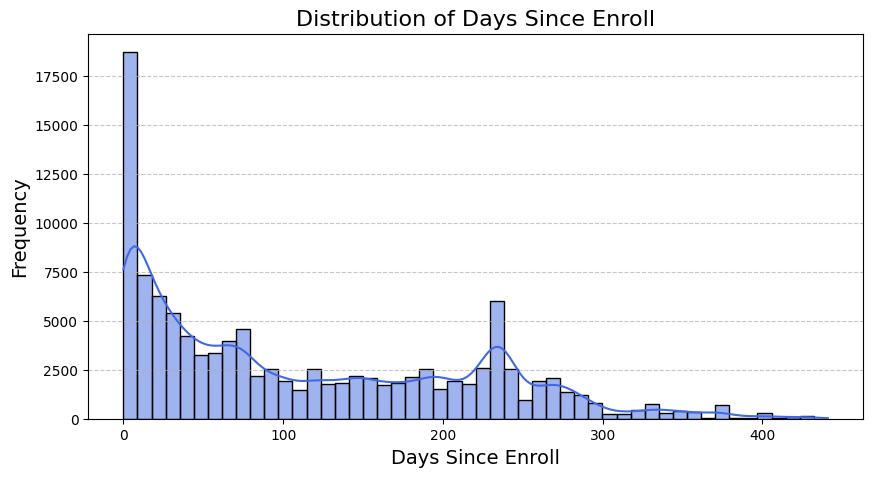

In [35]:
plt.figure(figsize=(10, 5))
sns.histplot(reply['days_since_enroll'], bins=50, kde=True, color='royalblue')
plt.xlabel('Days Since Enroll', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Days Since Enroll', fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Phase 1

In [36]:
Phase1_rep = reply[reply['days_since_enroll'] <= 14]

In [37]:
Phase1_rep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23913 entries, 0 to 146781
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   reply_id           23913 non-null  object        
 1   user_id            23913 non-null  object        
 2   course_id          23913 non-null  object        
 3   comment_id         23913 non-null  object        
 4   text               23913 non-null  object        
 5   create_time        23913 non-null  datetime64[ns]
 6   enroll_time        23913 non-null  datetime64[ns]
 7   days_since_enroll  23913 non-null  int64         
 8   num_words_rep      23913 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 1.8+ MB


In [38]:
# Tính tổng số chữ phản hồi của user trong phase 1
word_count_phase1 = Phase1_rep.groupby(['user_id', 'course_id'])['num_words_rep'].sum().reset_index(name='total_words_phase1')

# Đếm số lượng phản hồi trong phase 1
reply_count_phase1 = Phase1_rep.groupby(['user_id', 'course_id']).size().reset_index(name='reply_count_phase1')

result_phase1 = pd.merge(reply_count_phase1, word_count_phase1, on=['user_id', 'course_id'], how='outer')
print(result_phase1)

          user_id course_id  reply_count_phase1  total_words_phase1
0      U_10036301  C_936971                   1                   1
1      U_10036426  C_936971                   1                   5
2      U_10060289  C_948428                   3                  84
3      U_10060390  C_681074                   1                  76
4      U_10062271  C_735296                   1                   6
...           ...       ...                 ...                 ...
14744   U_9955256  C_936971                   1                   5
14745     U_99567  C_676664                   1                  51
14746     U_99567  C_696994                   1                   3
14747   U_9963608  C_936971                   1                   2
14748   U_9969882  C_696700                   2                   7

[14749 rows x 4 columns]


In [39]:
# Bước 1: Sắp xếp dữ liệu theo user_id, course_id, và create_time
Phase1_rep = Phase1_rep.sort_values(by=['user_id', 'course_id', 'create_time'])

# Bước 2: Xác định khoảng thời gian (bins)
def assign_time_bin(timestamp):
    """
    Chia ngày thành 48 khoảng thời gian (mỗi khoảng 30 phút) và gán bin tương ứng.
    """
    return (timestamp.hour * 60 + timestamp.minute) // 30

Phase1_rep['time_bin'] = Phase1_rep['create_time'].apply(assign_time_bin)

# Bước 3: Đếm số lượng reply trong mỗi khoảng thời gian
time_bin_counts1 = Phase1_rep.groupby(['user_id', 'course_id', 'time_bin']).size().reset_index(name='count')

# Bước 4: Tính tổng số reply của mỗi user trong từng khóa học
total_replies1 = Phase1_rep.groupby(['user_id', 'course_id']).size().reset_index(name='total_count')

# Gộp dữ liệu để tính xác suất
time_bin_counts1 = time_bin_counts1.merge(total_replies1, on=['user_id', 'course_id'], how='left')

# Bước 5: Tính xác suất xuất hiện của mỗi bin
time_bin_counts1['probability'] = time_bin_counts1['count'] / time_bin_counts1['total_count']

# Bước 6: Tính entropy theo công thức Shannon entropy
def calculate_entropy(probabilities):
    """
    Tính entropy theo công thức Shannon entropy.
    Loại bỏ giá trị xác suất bằng 0 để tránh lỗi log(0).
    """
    probabilities = probabilities[probabilities > 0]  # Loại bỏ giá trị 0
    return -np.sum(probabilities * np.log(probabilities)) if len(probabilities) > 1 else 0

entropy_values_phase1 = (
    time_bin_counts1.groupby(['user_id', 'course_id'])['probability']
    .apply(lambda x: calculate_entropy(x.values))
    .reset_index(name='entropy_time_reply_phase1')
)

# Hiển thị kết quả
print(entropy_values_phase1.head())

      user_id course_id  entropy_time_reply_phase1
0  U_10036301  C_936971                   0.000000
1  U_10036426  C_936971                   0.000000
2  U_10060289  C_948428                   0.636514
3  U_10060390  C_681074                   0.000000
4  U_10062271  C_735296                   0.000000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


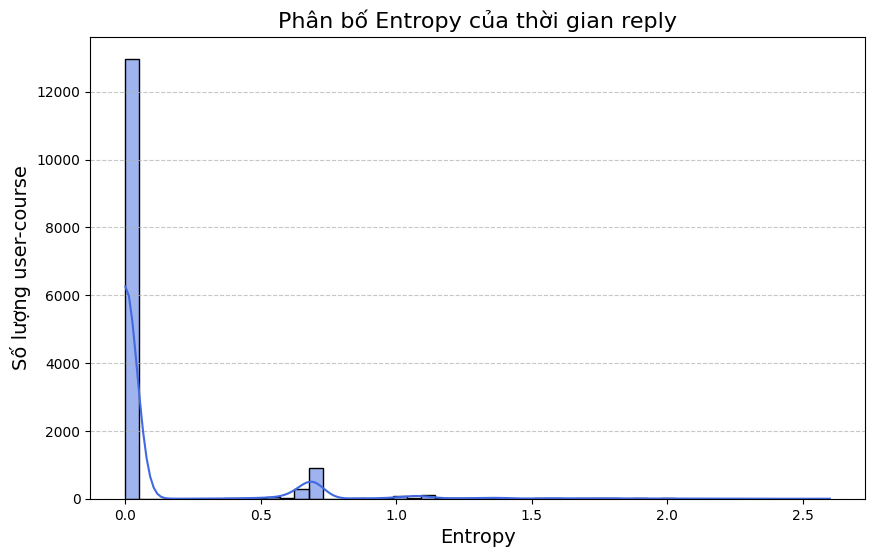

In [40]:
# Vẽ biểu đồ phân bố entropy
plt.figure(figsize=(10, 6))
sns.histplot(entropy_values_phase1["entropy_time_reply_phase1"], bins=50, kde=True, color="royalblue")

# Định dạng biểu đồ
plt.xlabel("Entropy", fontsize=14)
plt.ylabel("Số lượng user-course", fontsize=14)
plt.title("Phân bố Entropy của thời gian reply", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

Nhận xét:
- Biểu đồ này cho thấy rằng phần lớn user không có hoặc có rất ít hoạt động reply trên diễn đàn.
- Nhóm có entropy thấp (< 0.5): Reply vào khung giờ cố định hoặc rất ít hoạt động.
- Nhóm có entropy trung bình (0.5 - 1.5): Reply có quy luật nhưng vẫn có chút linh hoạt.
- Nhóm có entropy cao (> 2.0): Thói quen học tập không cố định, reply vào nhiều khung giờ khác nhau.

In [41]:
Phase1_reply = result_phase1.merge(entropy_values_phase1, on=['user_id', 'course_id'], how='outer')

# Nếu một số user-course không có entropy, điền giá trị mặc định là 0
Phase1_reply['entropy_time_reply_phase1'] = Phase1_reply['entropy_time_reply_phase1'].fillna(0)

print(Phase1_reply.head())

      user_id course_id  reply_count_phase1  total_words_phase1  \
0  U_10036301  C_936971                   1                   1   
1  U_10036426  C_936971                   1                   5   
2  U_10060289  C_948428                   3                  84   
3  U_10060390  C_681074                   1                  76   
4  U_10062271  C_735296                   1                   6   

   entropy_time_reply_phase1  
0                   0.000000  
1                   0.000000  
2                   0.636514  
3                   0.000000  
4                   0.000000  


# Phase 2

In [42]:
Phase2_rep = reply[(reply['days_since_enroll'] > 14) & (reply['days_since_enroll'] <= 28)]

In [43]:
Phase2_rep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9958 entries, 65 to 146757
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   reply_id           9958 non-null   object        
 1   user_id            9958 non-null   object        
 2   course_id          9958 non-null   object        
 3   comment_id         9958 non-null   object        
 4   text               9958 non-null   object        
 5   create_time        9958 non-null   datetime64[ns]
 6   enroll_time        9958 non-null   datetime64[ns]
 7   days_since_enroll  9958 non-null   int64         
 8   num_words_rep      9958 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 778.0+ KB


In [44]:
# Tính tổng số chữ phản hồi của user trong phase 2
word_count_phase2 = Phase2_rep.groupby(['user_id', 'course_id'])['num_words_rep'].sum().reset_index(name='total_words_phase2')

# Đếm số lượng phản hồi trong phase 2
reply_count_phase2 = Phase2_rep.groupby(['user_id', 'course_id']).size().reset_index(name='reply_count_phase2')

result_phase2 = pd.merge(reply_count_phase2, word_count_phase2, on=['user_id', 'course_id'], how='outer')
print(result_phase2)

         user_id  course_id  reply_count_phase2  total_words_phase2
0     U_10037312   C_936971                   1                   8
1     U_10060390   C_681074                   1                   4
2     U_10060401   C_862969                   7                  52
3     U_10097786   C_682813                   1                   1
4      U_1012380   C_696689                   1                  14
...          ...        ...                 ...                 ...
4509   U_9941870   C_770738                   1                  15
4510   U_9952866  C_2290629                   1                  21
4511   U_9955542   C_936971                   1                   3
4512     U_99579   C_819285                   1                  15
4513     U_99579   C_916828                   4                 361

[4514 rows x 4 columns]


In [45]:
# Sắp xếp dữ liệu theo user_id, course_id, và create_time
Phase2_rep = Phase2_rep.sort_values(by=['user_id', 'course_id', 'create_time'])

# Xác định khoảng thời gian (bins)
Phase2_rep['time_bin'] = Phase2_rep['create_time'].apply(assign_time_bin)

# Đếm số lượng reply trong mỗi khoảng thời gian
time_bin_counts2 = Phase2_rep.groupby(['user_id', 'course_id', 'time_bin']).size().reset_index(name='count')

# Tính tổng số reply của mỗi user trong từng khóa học
total_replies2 = Phase2_rep.groupby(['user_id', 'course_id']).size().reset_index(name='total_count')

time_bin_counts2 = time_bin_counts2.merge(total_replies2, on=['user_id', 'course_id'], how='left')

# Tính xác suất xuất hiện của mỗi bin
time_bin_counts2['probability'] = time_bin_counts2['count'] / time_bin_counts2['total_count']

# Tính entropy theo công thức Shannon entropy
entropy_values_phase2 = (
    time_bin_counts2.groupby(['user_id', 'course_id'])['probability']
    .apply(lambda x: calculate_entropy(x.values))
    .reset_index(name='entropy_time_reply_phase2')
)

# Hiển thị kết quả
print(entropy_values_phase2.head())

      user_id course_id  entropy_time_reply_phase2
0  U_10037312  C_936971                   0.000000
1  U_10060390  C_681074                   0.000000
2  U_10060401  C_862969                   1.078992
3  U_10097786  C_682813                   0.000000
4   U_1012380  C_696689                   0.000000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


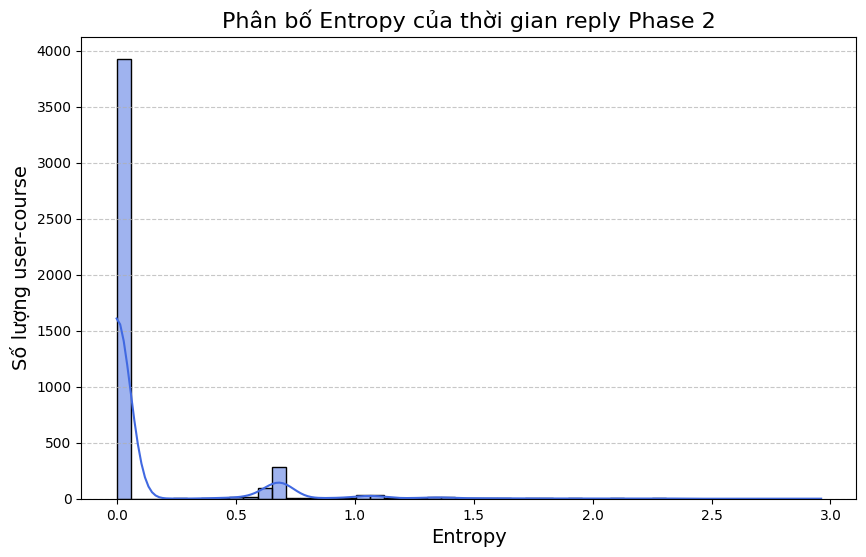

In [46]:
# Vẽ biểu đồ phân bố entropy
plt.figure(figsize=(10, 6))
sns.histplot(entropy_values_phase2["entropy_time_reply_phase2"], bins=50, kde=True, color="royalblue")

# Định dạng biểu đồ
plt.xlabel("Entropy", fontsize=14)
plt.ylabel("Số lượng user-course", fontsize=14)
plt.title("Phân bố Entropy của thời gian reply Phase 2", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

In [47]:
Phase2_reply = result_phase2.merge(entropy_values_phase2, on=['user_id', 'course_id'], how='outer')

# Nếu một số user-course không có entropy, điền giá trị mặc định là 0
Phase2_reply['entropy_time_reply_phase2'] = Phase2_reply['entropy_time_reply_phase2'].fillna(0)

print(Phase2_reply.head())

      user_id course_id  reply_count_phase2  total_words_phase2  \
0  U_10037312  C_936971                   1                   8   
1  U_10060390  C_681074                   1                   4   
2  U_10060401  C_862969                   7                  52   
3  U_10097786  C_682813                   1                   1   
4   U_1012380  C_696689                   1                  14   

   entropy_time_reply_phase2  
0                   0.000000  
1                   0.000000  
2                   1.078992  
3                   0.000000  
4                   0.000000  


# Phase 3

In [48]:
Phase3_rep = reply[(reply['days_since_enroll'] > 28) & (reply['days_since_enroll'] <= 42)]

In [49]:
Phase3_rep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7188 entries, 244 to 146802
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   reply_id           7188 non-null   object        
 1   user_id            7188 non-null   object        
 2   course_id          7188 non-null   object        
 3   comment_id         7188 non-null   object        
 4   text               7188 non-null   object        
 5   create_time        7188 non-null   datetime64[ns]
 6   enroll_time        7188 non-null   datetime64[ns]
 7   days_since_enroll  7188 non-null   int64         
 8   num_words_rep      7188 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 561.6+ KB


In [50]:
# Tính tổng số chữ phản hồi của user trong phase 3
word_count_phase3 = Phase3_rep.groupby(['user_id', 'course_id'])['num_words_rep'].sum().reset_index(name='total_words_phase3')

# Đếm số lượng phản hồi trong phase 3
reply_count_phase3 = Phase3_rep.groupby(['user_id', 'course_id']).size().reset_index(name='reply_count_phase3')

result_phase3 = pd.merge(reply_count_phase3, word_count_phase3, on=['user_id', 'course_id'], how='outer')
print(result_phase3)

         user_id  course_id  reply_count_phase3  total_words_phase3
0     U_10034442   C_696889                   1                   3
1     U_10060390   C_681074                   6                 331
2     U_10060580   C_681074                   1                   7
3     U_10136965  C_1738993                  13                  81
4     U_10175340  C_1647264                   4                 327
...          ...        ...                 ...                 ...
2973   U_9884041   C_789961                   1                   4
2974   U_9941870   C_735157                   1                  17
2975   U_9952866   C_674953                   1                   2
2976     U_99579   C_819285                   1                  23
2977     U_99772  C_1903985                   1                  19

[2978 rows x 4 columns]


In [51]:
# Bước 1: Sắp xếp dữ liệu theo user_id, course_id, và create_time
Phase3_rep = Phase3_rep.sort_values(by=['user_id', 'course_id', 'create_time'])

# Bước 2: Xác định khoảng thời gian (bins)
Phase3_rep['time_bin'] = Phase3_rep['create_time'].apply(assign_time_bin)

# Bước 3: Đếm số lượng reply trong mỗi khoảng thời gian
time_bin_counts3 = Phase3_rep.groupby(['user_id', 'course_id', 'time_bin']).size().reset_index(name='count')

# Bước 4: Tính tổng số reply của mỗi user trong từng khóa học
total_replies3 = Phase3_rep.groupby(['user_id', 'course_id']).size().reset_index(name='total_count')

time_bin_counts3 = time_bin_counts3.merge(total_replies3, on=['user_id', 'course_id'], how='left')

# Bước 5: Tính xác suất xuất hiện của mỗi bin
time_bin_counts3['probability'] = time_bin_counts3['count'] / time_bin_counts3['total_count']

# Bước 6: Tính entropy theo công thức Shannon entropy
entropy_values_phase3 = (
    time_bin_counts3.groupby(['user_id', 'course_id'])['probability']
    .apply(lambda x: calculate_entropy(x.values))
    .reset_index(name='entropy_time_reply_phase3')
)

# Hiển thị kết quả
print(entropy_values_phase3.head())

      user_id  course_id  entropy_time_reply_phase3
0  U_10034442   C_696889                   0.000000
1  U_10060390   C_681074                   1.329661
2  U_10060580   C_681074                   0.000000
3  U_10136965  C_1738993                   0.000000
4  U_10175340  C_1647264                   1.039721


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


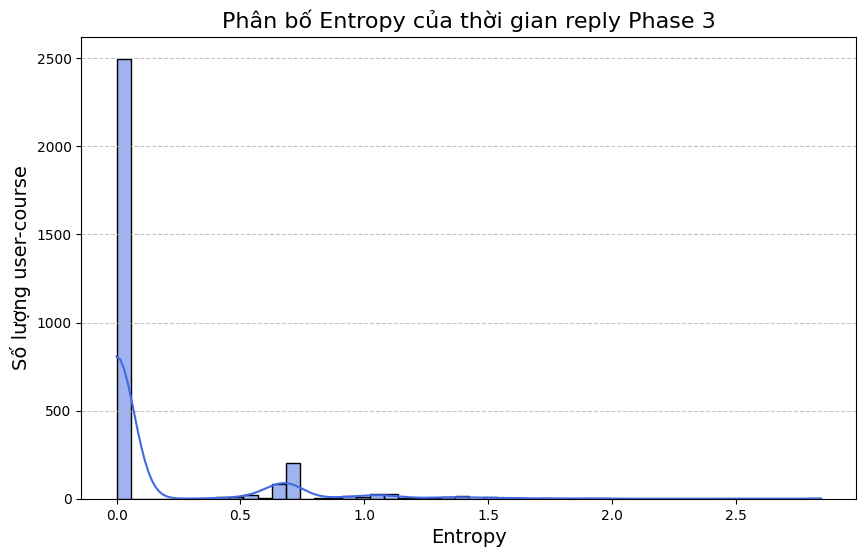

In [52]:
# Vẽ biểu đồ phân bố entropy
plt.figure(figsize=(10, 6))
sns.histplot(entropy_values_phase3["entropy_time_reply_phase3"], bins=50, kde=True, color="royalblue")

# Định dạng biểu đồ
plt.xlabel("Entropy", fontsize=14)
plt.ylabel("Số lượng user-course", fontsize=14)
plt.title("Phân bố Entropy của thời gian reply Phase 3", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

In [53]:
Phase3_reply = result_phase3.merge(entropy_values_phase3, on=['user_id', 'course_id'], how='left')

# Nếu một số user-course không có entropy, điền giá trị mặc định là 0
Phase3_reply['entropy_time_reply_phase3'] = Phase3_reply['entropy_time_reply_phase3'].fillna(0)

print(Phase3_reply.head())

      user_id  course_id  reply_count_phase3  total_words_phase3  \
0  U_10034442   C_696889                   1                   3   
1  U_10060390   C_681074                   6                 331   
2  U_10060580   C_681074                   1                   7   
3  U_10136965  C_1738993                  13                  81   
4  U_10175340  C_1647264                   4                 327   

   entropy_time_reply_phase3  
0                   0.000000  
1                   1.329661  
2                   0.000000  
3                   0.000000  
4                   1.039721  


# Phase 4

In [54]:
Phase4_rep = reply[(reply['days_since_enroll'] > 42) & (reply['days_since_enroll'] <= 56)]

In [55]:
Phase4_rep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6069 entries, 503 to 146805
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   reply_id           6069 non-null   object        
 1   user_id            6069 non-null   object        
 2   course_id          6069 non-null   object        
 3   comment_id         6069 non-null   object        
 4   text               6069 non-null   object        
 5   create_time        6069 non-null   datetime64[ns]
 6   enroll_time        6069 non-null   datetime64[ns]
 7   days_since_enroll  6069 non-null   int64         
 8   num_words_rep      6069 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 474.1+ KB


In [56]:
# Tính tổng số chữ phản hồi của user trong phase 4
word_count_phase4 = Phase4_rep.groupby(['user_id', 'course_id'])['num_words_rep'].sum().reset_index(name='total_words_phase4')

# Đếm số lượng phản hồi trong phase 4
reply_count_phase4 = Phase4_rep.groupby(['user_id', 'course_id']).size().reset_index(name='reply_count_phase4')

result_phase4 = pd.merge(reply_count_phase4, word_count_phase4, on=['user_id', 'course_id'], how='outer')
print(result_phase4)

         user_id course_id  reply_count_phase4  total_words_phase4
0       U_100306  C_697018                   1                   2
1     U_10036304  C_936971                   1                   1
2     U_10099780  C_948417                  15                 269
3     U_10136965  C_789278                   1                  45
4     U_10150412  C_679390                   7                 359
...          ...       ...                 ...                 ...
2151   U_9805409  C_682469                   1                  21
2152     U_98262  C_948417                   1                   5
2153   U_9826537  C_947260                   1                  21
2154   U_9860774  C_735046                   5                 190
2155    U_989735  C_735164                   1                   4

[2156 rows x 4 columns]


In [57]:
# Bước 1: Sắp xếp dữ liệu theo user_id, course_id, và create_time
Phase4_rep = Phase4_rep.sort_values(by=['user_id', 'course_id', 'create_time'])

# Bước 2: Xác định khoảng thời gian (bins)
Phase4_rep['time_bin'] = Phase4_rep['create_time'].apply(assign_time_bin)

# Bước 3: Đếm số lượng reply trong mỗi khoảng thời gian
time_bin_counts4 = Phase4_rep.groupby(['user_id', 'course_id', 'time_bin']).size().reset_index(name='count')

# Bước 4: Tính tổng số reply của mỗi user trong từng khóa học
total_replies4 = Phase4_rep.groupby(['user_id', 'course_id']).size().reset_index(name='total_count')

time_bin_counts4 = time_bin_counts4.merge(total_replies4, on=['user_id', 'course_id'], how='left')

# Bước 5: Tính xác suất xuất hiện của mỗi bin
time_bin_counts4['probability'] = time_bin_counts4['count'] / time_bin_counts4['total_count']

# Bước 6: Tính entropy theo công thức Shannon entropy
entropy_values_phase4 = (
    time_bin_counts4.groupby(['user_id', 'course_id'])['probability']
    .apply(lambda x: calculate_entropy(x.values))
    .reset_index(name='entropy_time_reply_phase4')
)

# Hiển thị kết quả
print(entropy_values_phase4.head())

      user_id course_id  entropy_time_reply_phase4
0    U_100306  C_697018                   0.000000
1  U_10036304  C_936971                   0.000000
2  U_10099780  C_948417                   1.235145
3  U_10136965  C_789278                   0.000000
4  U_10150412  C_679390                   1.351784


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


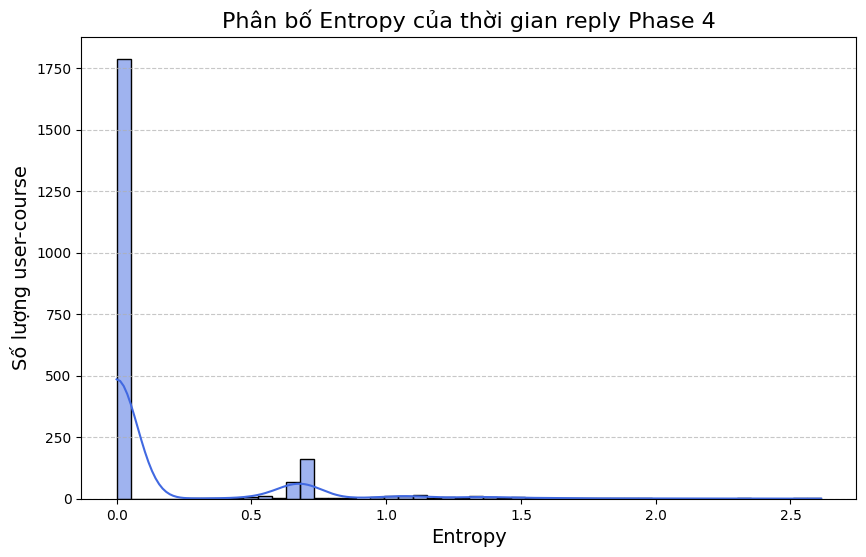

In [58]:
# Vẽ biểu đồ phân bố entropy
plt.figure(figsize=(10, 6))
sns.histplot(entropy_values_phase4["entropy_time_reply_phase4"], bins=50, kde=True, color="royalblue")

# Định dạng biểu đồ
plt.xlabel("Entropy", fontsize=14)
plt.ylabel("Số lượng user-course", fontsize=14)
plt.title("Phân bố Entropy của thời gian reply Phase 4", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()

In [59]:
Phase4_reply = result_phase4.merge(entropy_values_phase4, on=['user_id', 'course_id'], how='outer')

# Nếu một số user-course không có entropy, điền giá trị mặc định là 0
Phase4_reply['entropy_time_reply_phase4'] = Phase4_reply['entropy_time_reply_phase4'].fillna(0)

print(Phase4_reply.head())

      user_id course_id  reply_count_phase4  total_words_phase4  \
0    U_100306  C_697018                   1                   2   
1  U_10036304  C_936971                   1                   1   
2  U_10099780  C_948417                  15                 269   
3  U_10136965  C_789278                   1                  45   
4  U_10150412  C_679390                   7                 359   

   entropy_time_reply_phase4  
0                   0.000000  
1                   0.000000  
2                   1.235145  
3                   0.000000  
4                   1.351784  


In [60]:
# Gộp dữ liệu của các phase lại
Phase2 = Phase2_reply.merge(Phase1_reply, on=['user_id', 'course_id'], how='outer')

Phase3 = Phase3_reply.merge(Phase2, on=['user_id', 'course_id'], how='outer')

all_phases_reply = Phase4_reply.merge(Phase3, on=['user_id', 'course_id'], how='outer')

all_phases_reply.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22162 entries, 0 to 22161
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    22162 non-null  object 
 1   course_id                  22162 non-null  object 
 2   reply_count_phase4         2156 non-null   float64
 3   total_words_phase4         2156 non-null   float64
 4   entropy_time_reply_phase4  2156 non-null   float64
 5   reply_count_phase3         2978 non-null   float64
 6   total_words_phase3         2978 non-null   float64
 7   entropy_time_reply_phase3  2978 non-null   float64
 8   reply_count_phase2         4514 non-null   float64
 9   total_words_phase2         4514 non-null   float64
 10  entropy_time_reply_phase2  4514 non-null   float64
 11  reply_count_phase1         14749 non-null  float64
 12  total_words_phase1         14749 non-null  float64
 13  entropy_time_reply_phase1  14749 non-null  flo

In [61]:
new_column_order = [
    'user_id', 
    'course_id', 
    'reply_count_phase1', 
    'total_words_phase1', 
    'entropy_time_reply_phase1', 
    'reply_count_phase2', 
    'total_words_phase2', 
    'entropy_time_reply_phase2', 
    'reply_count_phase3', 
    'total_words_phase3', 
    'entropy_time_reply_phase3', 
    'reply_count_phase4', 
    'total_words_phase4', 
    'entropy_time_reply_phase4'
]

# Sắp xếp lại thứ tự cột trong DataFrame
all_phases_reply = all_phases_reply[new_column_order]

all_phases_reply.head(10)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,user_id,course_id,reply_count_phase1,total_words_phase1,entropy_time_reply_phase1,reply_count_phase2,total_words_phase2,entropy_time_reply_phase2,reply_count_phase3,total_words_phase3,entropy_time_reply_phase3,reply_count_phase4,total_words_phase4,entropy_time_reply_phase4
0,U_100306,C_697018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0
1,U_10034442,C_696889,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.000000,NaN,NaN,NaN
2,U_10036301,C_936971,1.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,U_10036304,C_936971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
4,U_10036426,C_936971,1.0,5.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,U_10037312,C_936971,NaN,NaN,NaN,1.0,8.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
6,U_10060289,C_948428,3.0,84.0,0.636514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,U_10060390,C_681074,1.0,76.0,0.000000,1.0,4.0,0.000000,6.0,331.0,1.329661,NaN,NaN,NaN
8,U_10060401,C_862969,NaN,NaN,NaN,7.0,52.0,1.078992,NaN,NaN,NaN,NaN,NaN,NaN
9,U_10060580,C_681074,NaN,NaN,NaN,NaN,NaN,NaN,1.0,7.0,0.000000,NaN,NaN,NaN
